In [3]:
'''
First, we need to enable GPU in the Google Colab to get fast processing. 
We can enable it by going to ‘Runtime’ in Google Colab and then clicking 
on ‘Change runtime type’ and select GPU. Once it is enabled we will now 
import the required libraries for building the network.
'''

import pandas as pd
from matplotlib import pyplot
from math import sqrt 
import numpy as np
from IPython.display import display 
from keras.utils import np_utils
from keras.utils import plot_model
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from keras.optimizers import Adam, SGD
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [4]:
'''
The name of the data set is fer2013 which is an open-source data set that was made
publicly available for a Kaggle competition. It contains 48 X 48-pixel grayscale images of the face. 
There are seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral) present in the data. 
The CSV file contains two columns that are emotion that contains numeric code from 0-6 and a pixel 
column that includes a string surrounded in quotes for each image.
'''

data= pd.read_csv('fer2013.csv')
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [5]:
from pylab import rcParams
rcParams['figure.figsize'] = 15, 10

In [6]:
'''
There are about 28,700 training images, 3,600 validation images, and 3,600 images for testing. 
Out of these, approximately 5000 images are reserved for anger, 550 images are reserved for disgust emotion, 
5100 for fear, 9000 for happy face, 6000 for sad emotion, 4000 for surprise, and 6200 for neutral faces.
'''

data.emotion.value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

In [7]:
num_classes = 7
width = 48
height = 48
emotion_labels = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]
classes=np.array(("Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"))

In [8]:
data.Usage.value_counts() 

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

In [9]:
'''
We then create different lists of storing the testing and training image pixels. 
After this, we check if the pixel belongs to training then we append it into the 
training list & training labels. Similarly, for pixels belonging to the Private and Public test, 
we append it to validation and testing lists.
'''

X_train, y_train = [], []
X_val, y_val = [], []
X_test, y_test = [], []
for index, row in data.iterrows():
    k = row['pixels'].split(" ")
    if row['Usage'] == 'Training':
        X_train.append(np.array(k))
        y_train.append(row['emotion'])
    elif row['Usage'] == 'PublicTest':
        X_test.append(np.array(k))
        y_test.append(row['emotion'])
    elif row['Usage'] == 'PrivateTest':
        X_val.append(np.array(k))
        y_val.append(row['emotion'])

In [10]:
'''
Once we have added the pixel to the lists then we convert them into NumPy arrays and reshape X_train, 
X_val and X_test. After doing this we convert the training labels, 
validation labels and testing labels into categorical ones.
'''

X_train = np.array(X_train).astype(float)
y_train = np.array(y_train)
X_val = np.array(X_val).astype(float)
y_val = np.array(y_val)
X_test = np.array(X_test).astype(float)
y_test = np.array(y_test)

X_train = X_train.reshape(X_train.shape[0], 48, 48, 1)
X_val = X_val.reshape(X_val.shape[0], 48, 48, 1)
X_test = X_test.reshape(X_test.shape[0], 48, 48, 1)

y_train= np_utils.to_categorical(y_train, num_classes=num_classes)
y_val= np_utils.to_categorical(y_val, num_classes=num_classes)
y_test = np_utils.to_categorical(y_test, num_classes=num_classes)

In [11]:
'''
We considered the following network architecture in our investigation:

We initialized our model by dividing it the convolution layers into four different blocks. 
The first block contains two convolution layers with 64 different filters and 
‘ReLU’ activation unit followed by a Max pooling layer with two strides. 
The next block contains two convolution layers with 128 different filters and 
‘ReLU’ activation unit followed by a Max pooling layer with two strides. 
Third block contains three convolution layers with 128 different filters and 
‘ReLU’ activation unit followed by a Max pooling layer with two strides. 
Finally, the fourth block contains 3 convolution layers with 512 different filters and 
‘ReLU’ activation unit followed by a Max pooling layer with two strides.

Then the model was flattened and two dense layer having 4096 neurons along with 
‘ReLU’ activation function and a dropout of 0.3 was added. Lastly, an output layer 
with 7 neurons (each neuron representing a specific class) was added to the previous 
fully connected layer and outputs the required classes or their probabilities using softmax activation function.
'''

def CNN_Model( input_shape = (48,48,1) ):
    # first input model
    num_classes = 7
    
    model = Sequential()

    #the 1-st block
    model.add(Conv2D(64, 3, activation = 'relu', padding = "same", input_shape = input_shape))
    model.add(Conv2D(64, 3, padding = "same", activation='relu'))
    model.add(MaxPool2D( (2,2), strides = 2))

    model.add(Conv2D(128, 3, padding = "same", activation = 'relu'))
    model.add(Conv2D(128, 3, padding = "same", activation = 'relu'))
    model.add(MaxPool2D( (2,2), strides = 2))

    model.add(Conv2D(256, 3, padding = "same", activation = 'relu'))
    model.add(Conv2D(256, 3, padding = "same", activation = 'relu'))
    model.add(Conv2D(256, 3, padding = "same", activation = 'relu'))
    model.add(MaxPool2D( (2,2), strides = 2))

    model.add(Conv2D(512, 3, padding = "same", activation = 'relu'))
    model.add(Conv2D(512, 3, padding = "same", activation = 'relu'))
    model.add(Conv2D(512, 3, padding = "same", activation = 'relu'))
    model.add(MaxPool2D( (2,2), strides = 2))

    model.add(Flatten())
    model.add(Dense(4096, activation = 'relu'))
    model.add(Dropout(0.3))
    model.add(Dense(4096, activation = 'relu'))
    model.add(Dropout(0.3))
    model.add(Dense(num_classes, activation = 'softmax'))
    # summary layers
    print(model.summary())

    return model

In [12]:
model = CNN_Model()

'''
After this, we compile the model using Adam as an optimizer, 
loss as categorical cross-entropy, and metrics as accuracy as shown below.
'''

model.compile(loss='categorical_crossentropy', optimizer=Adam( lr=0.0001, decay=1e-6 ), metrics = ['accuracy']) 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 64)        36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 12, 12, 256)       2

In [13]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)

In [15]:
'''
After compiling the model we then fit the data for training and validation. 
Here, we are taking the batch size to be 32 with 30 epochs. 
You can tune them according to your wish.
'''

history = model.fit( X_train, y_train, batch_size = 32, epochs = 30, verbose = 1, validation_data = (X_val, y_val))

Epoch 1/30
898/898 [==============================] - 44s 49ms/step - loss: 1.4963 - accuracy: 0.4150 - val_loss: 1.3386 - val_accuracy: 0.4887
Epoch 2/30
898/898 [==============================] - 43s 48ms/step - loss: 1.2595 - accuracy: 0.5173 - val_loss: 1.2131 - val_accuracy: 0.5322
Epoch 3/30
898/898 [==============================] - 43s 48ms/step - loss: 1.1109 - accuracy: 0.5757 - val_loss: 1.1378 - val_accuracy: 0.5522
Epoch 4/30
898/898 [==============================] - 43s 48ms/step - loss: 0.9683 - accuracy: 0.6351 - val_loss: 1.0713 - val_accuracy: 0.5837
Epoch 5/30
898/898 [==============================] - 44s 49ms/step - loss: 0.8050 - accuracy: 0.6983 - val_loss: 1.1264 - val_accuracy: 0.5862
Epoch 6/30
898/898 [==============================] - 43s 48ms/step - loss: 0.6037 - accuracy: 0.7792 - val_loss: 1.2485 - val_accuracy: 0.5949
Epoch 7/30
898/898 [==============================] - 43s 48ms/step - loss: 0.4054 - accuracy: 0.8557 - val_loss: 1.4309 - val_accuracy:

<Figure size 432x288 with 0 Axes>

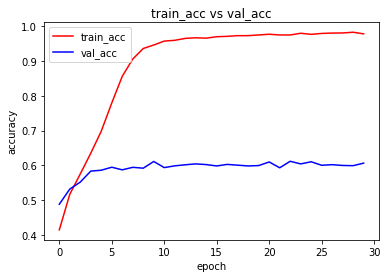

<Figure size 432x288 with 0 Axes>

In [17]:
# visualizing losses and accuracy
%matplotlib inline

'''
We are plotting the training and validation accuracy of thye model
with respect to the number of epochs 
'''

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(len(train_acc))

plt.plot(epochs, train_acc, 'r', label = 'train_acc')
plt.plot(epochs, val_acc, 'b', label = 'val_acc')
plt.title('train_acc vs val_acc')
plt.xlabel( 'epoch' )
plt.ylabel( 'accuracy' )
plt.legend()
plt.figure()

In [20]:
'''
We now serialize the model to JSON and save the model weights in an hd5 file so 
that we can make use of this file to make predictions rather than training the network again. 
'''

model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
    model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [18]:
loss = model.evaluate(X_test, y_test) 
print("Test Loss " + str(loss[0]))
print("Test Acc: " + str(loss[1]))

113/113 [==============================] - 2s 18ms/step - loss: 2.5470 - accuracy: 0.5952
Test Loss 2.5470142364501953
Test Acc: 0.5951518416404724


In [ ]:
'''
As the name of the function suggests, we are plotting the confusion matrix 
with the help of this function
'''

def plot_confusion_matrix(y_test, y_pred, classes,
                          normalize=False,
                          title='Unnormalized confusion matrix',
                          cmap=plt.cm.Blues):
    cm = confusion_matrix(y_test, y_pred)
    
    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 2)
        
    np.set_printoptions(precision=2)
        
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.min() + (cm.max() - cm.min()) / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    return cm

In [25]:
'''
Once the training has been done we can evaluate the model and compute loss and accuracy using the below code. 
'''

y_pred_ = model.predict(X_test, verbose=1)
y_pred = np.argmax(y_pred_, axis=1)
y_te = np.argmax(y_test, axis=1)

113/113 [==============================] - 1s 12ms/step


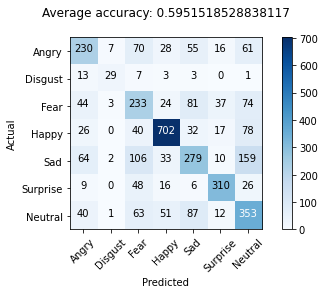

In [28]:
cm = plot_confusion_matrix(y_test=y_te, y_pred=y_pred,
                      classes=classes,
                      normalize=False,
                      #cmap=plt.cm.Greys,
                      title='Average accuracy: ' + str(np.sum(y_pred == y_te)/len(y_te)) + '\n')

In [20]:
'''
After performing the task of classification, not only the test dataset accuracy 
but also other performance metrics, namely , precision, recall, and F1 score were evaluated.
'''

TP = np.diag(cm) 
FP = np.sum(cm, axis=0) - TP
FN = np.sum(cm, axis=1) - TP
num_classes = len(cm)
TN = []
for i in range(num_classes):
    temp = np.delete(cm, i, 0)    # delete ith row
    temp = np.delete(temp, i, 1)  # delete ith column
    TN.append(sum(sum(temp)))
precision = TP/(TP+FP)
recall = TP/(TP+FN)
F1 = 2*(precision*recall)/(precision+recall)

In [22]:
print(precision)

[0.5399061  0.69047619 0.41093474 0.81913652 0.51381215 0.77114428
 0.46941489]


In [23]:
print(recall)

[0.49250535 0.51785714 0.46975806 0.78435754 0.42725881 0.74698795
 0.5815486 ]


In [24]:
print(F1)

[0.51511758 0.59183673 0.43838194 0.80136986 0.46655518 0.75887393
 0.51949963]


In [25]:
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print(np.diag(cm)) 

[0.49250535 0.51785714 0.46975806 0.78435754 0.42725881 0.74698795
 0.5815486 ]
